# Librairies

In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 

from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

from pandas_profiling import ProfileReport
import missingno

import warnings
warnings.filterwarnings("ignore")

# Exploration des données

In [2]:
data = pd.read_csv("data.csv", index_col=0)
data = data.set_index("index")
data.tail()

date  cheveux   age   exp  salaire sexe   diplome specialite  \
index                                                                       
19995  2012-03-10     roux  47.0   9.0  35723.0    M   licence   geologie   
19996  2010-09-19  chatain  38.0  10.0  33570.0    F    master   geologie   
19997  2010-09-02  chatain  23.0   6.0  33751.0    F  doctorat  detective   
19998  2011-12-06  chatain  33.0  11.0  34167.0    F   licence  detective   
19999  2010-11-29     brun  35.0  14.0  44499.0    M       bac   geologie   

         note dispo  embauche  
index                          
19995   66.47   non         0  
19996   62.29   non         1  
19997  103.48   oui         0  
19998   73.35   non         0  
19999   45.62   non         0

In [3]:
print('Nmbr de lignes = {} / Nmbr de colonnes = {}'.format(*data.shape))

Nmbr de lignes = 20000 / Nmbr de colonnes = 11


Je vais lancer le profiling des données pour avoir ainsi un rapport sur les données et ainsi voir d'abord les distributions et les données manquantes.

In [4]:
profile = ProfileReport(data, title="Rapport Data brut", explorative=True)

In [5]:
profile

Là je vais essayer de voir les données manquantes et ainsi definir une stratégie

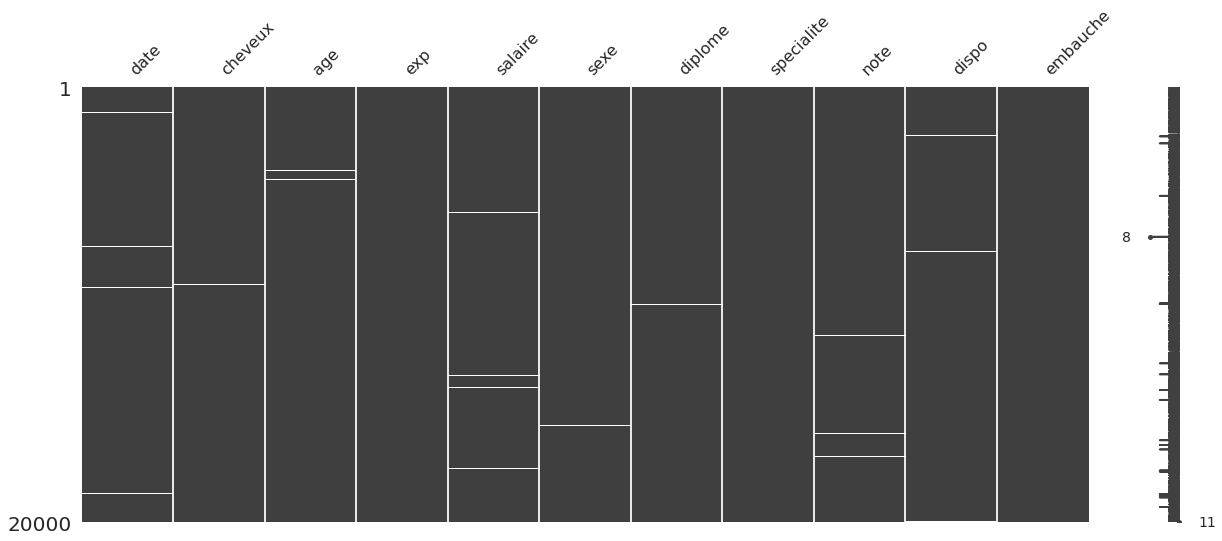

In [5]:
missingno.matrix(data, figsize = (20,8))

In [6]:
data.isnull().sum()

date           91
cheveux       103
age            91
exp            96
salaire        95
sexe          100
diplome       110
specialite     93
note          114
dispo         106
embauche        0
dtype: int64

In [27]:
_data = data.copy()

Comparé à la taille des données, les données manquantes représentent 0.5% des données globales ce qui n'est pas représentatif.
J'aurais pu les supprimer mais je préfere continuer l'exercice en les imputants.

Je vais d'abord commencer avec les données catégoriques (type 'object'), et l'idée c'est de remplacer les données manquantes par une valeur aléatoire qui respecterait la probabilité de distribution de la variable.

In [28]:
(_data.select_dtypes(include=['object'])).columns.tolist()

['date', 'cheveux', 'sexe', 'diplome', 'specialite', 'dispo']

Par choix, je vais supprimer la variable date car non representative du contexte de recrutement.
A moins qu'on puisse extraire le mois et année pour ainsi trouver une certaine saisonalité dans le recrutement qui elle pourrait impacter la décision donc notre variable à prédire.

In [29]:
_data.drop(['date'], axis=1, inplace=True)

### Variable : Cheveux

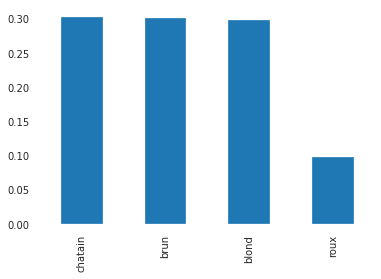

In [30]:
cheveux = _data.cheveux.value_counts(normalize=True)
cheveux.plot(kind='bar')

In [31]:
_missing = _data['cheveux'].isnull()
_data.loc[_missing, 'cheveux'] = pd.np.random.choice(cheveux.index, size=len(_data[_missing]),
                                                     p=cheveux.values/cheveux.values.sum())

### Variable : Sexe

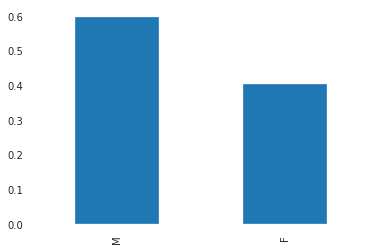

In [32]:
sexe = _data.sexe.value_counts(normalize=True)
sexe.plot(kind='bar')

In [33]:
_missing = _data['sexe'].isnull()
_data.loc[_missing, 'sexe'] = pd.np.random.choice(sexe.index, size=len(_data[_missing]),
                                                     p=sexe.values/sexe.values.sum())

### Variable : Diplome

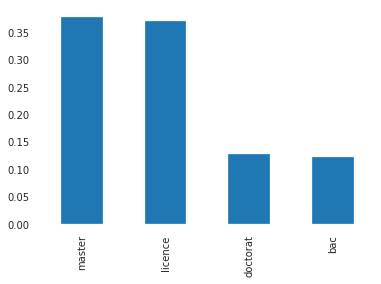

In [34]:
diplome = _data.diplome.value_counts(normalize=True)
diplome.plot(kind='bar')

In [35]:
_missing = _data['diplome'].isnull()
_data.loc[_missing, 'diplome'] = pd.np.random.choice(diplome.index, size=len(_data[_missing]),
                                                     p=diplome.values/diplome.values.sum())

### Variable : Specialite

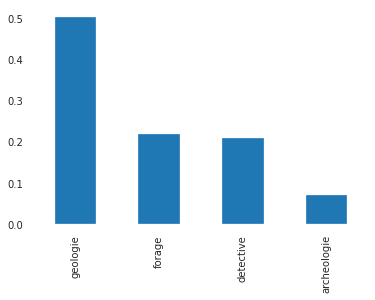

In [36]:
specialite = _data.specialite.value_counts(normalize=True)
specialite.plot(kind='bar')

In [37]:
_missing = _data['specialite'].isnull()
_data.loc[_missing, 'specialite'] = pd.np.random.choice(specialite.index, size=len(_data[_missing]),
                                                     p=specialite.values/specialite.values.sum())

### Variable : Dispo

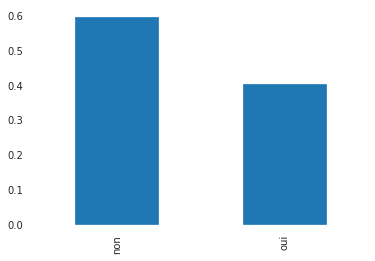

In [38]:
dispo = _data.dispo.value_counts(normalize=True)
dispo.plot(kind='bar')

In [39]:
_missing = _data['dispo'].isnull()
_data.loc[_missing, 'dispo'] = pd.np.random.choice(dispo.index, size=len(_data[_missing]),
                                                     p=dispo.values/dispo.values.sum())

Maintenant je vais vérifier que toutes les variables catégoriques ci dessus ne comprennent pas de valeurs nulles.

In [40]:
_data.isnull().sum()

cheveux         0
age            91
exp            96
salaire        95
sexe            0
diplome         0
specialite      0
note          114
dispo           0
embauche        0
dtype: int64

A partir du profiling que j'ai pu voir au début j'ai pu remarquer la présence de valeur anormales pour les variables age, exp et note. Cependant le salaire suivrait également le même traitement et donc l'idée c'est d'imputer les valeurs qui representent un entier par la médiane de la distribution et les valeurs réelles (flotante) par la moyenne.

J'aurais pu également choisir aléatoirement un int ou float à partir de la distribution.

Donc le travail se fera en 2 étapes, transformer les valeurs anormales en NaN grace à un mask et puis imputer toutes les valeurs manquantes en faisant un groupby suivant une logique "humaine".
ex: Si une personne a un diplome de doctorat et travaillant comme détective donc on pourrait dire qu'il a un age de 45 ans par exemple.
Un sort de clustering utilisant les variables categoriques pour imputer les autres variables.

### Variable: Age

J'ai choisi 16 ans (age minimal légal pour le travail en France) comme étant la limite minimale pour estimer que les données sont faussés.

Et l'imputation se fera en utilisant les variables explicatives diplome et specialite.

In [41]:
age_minimum_legal = 16
_data.age.mask(_data.age < age_minimum_legal, inplace=True)

_data.age.fillna(_data.groupby(["diplome", "specialite"])["age"].transform(np.median), inplace=True)

### Variable: Exp

L'experience ne peut avoir que des valeurs positives.

Et l'imputation se fera en utilisant les variables explicatives diplome et specialite.

In [42]:
_data.exp.mask(_data.exp < 0, inplace=True)

_data.exp.fillna(_data.groupby(["specialite", "diplome"])["exp"].transform(np.median), inplace=True)

### Variable: Salaire

Ici j'ai choisi le Smic Francais mensuel 1522 euros (reporté sur 12 mois) comme réference pour le salaire minimum.

Et l'imputation se fera en utilisant les variables explicatives diplome et specialite et exp.

In [44]:
salaire_minimum = 1522*12
_data.salaire.mask(_data.salaire < salaire_minimum, inplace=True)

_data.salaire.fillna(_data.groupby(["diplome", "exp", "specialite"])["salaire"].transform(np.mean), inplace=True)

### Variable:  Score

D'aprés la documentation le score ne dépasse pas la note de 100 et est positive.
J'ai pu remarqué que toutes les notes à partir du profiling était positive d'ou l'absence de la limite basse de 0.

Et l'imputation se fera en utilisant les variables explicatives diplome et specialite et exp, car il se peut que les test d'une specialite donnée soient plus difficiles que les autres et puis l'experience pourrait jouer un role sur la qualité des réponses.

In [46]:
note_maximum = 100
_data.note.mask(_data.note > note_maximum, inplace=True)

_data.note.fillna(_data.groupby(["diplome", "exp", "specialite"])["note"].transform(np.mean), inplace=True)

Je relance le test pour vérifier que toutes les variables ont bien été imputé.

In [48]:
_data.isnull().sum()

cheveux       0
age           0
exp           0
salaire       0
sexe          0
diplome       0
specialite    0
note          3
dispo         0
embauche      0
dtype: int64

On remarque qu'il y a toujours 3 valeurs dans note qui n'ont pas été rempli (car ne trouvant pas de similarité grace au clustering par groupby).

Et la je les remplacerais directement par la moyenne globale des notes.

In [49]:
_data.note.fillna(_data.note.mean(), inplace=True)

In [50]:
_data.isnull().sum()

cheveux       0
age           0
exp           0
salaire       0
sexe          0
diplome       0
specialite    0
note          0
dispo         0
embauche      0
dtype: int64

Là toutes les valeurs manquantes ont été remplacé.

Et là je relance mon profiling pour avoir une analyse globale plus en détails.

In [51]:
clean_profile = ProfileReport(_data, title="Clean Profiling Report", explorative=True)

In [52]:
clean_profile

Maintenant je vais encoder les variables catégoriques pour ainsi faire des analyses plus détailler.

In [53]:
encode_col = _data.select_dtypes(include=['object']).columns.tolist()
encode_col

['cheveux', 'sexe', 'diplome', 'specialite', 'dispo']

In [54]:
le = preprocessing.LabelEncoder()
for col in encode_col:
    _data[col] = le.fit_transform(_data[col].astype(str))

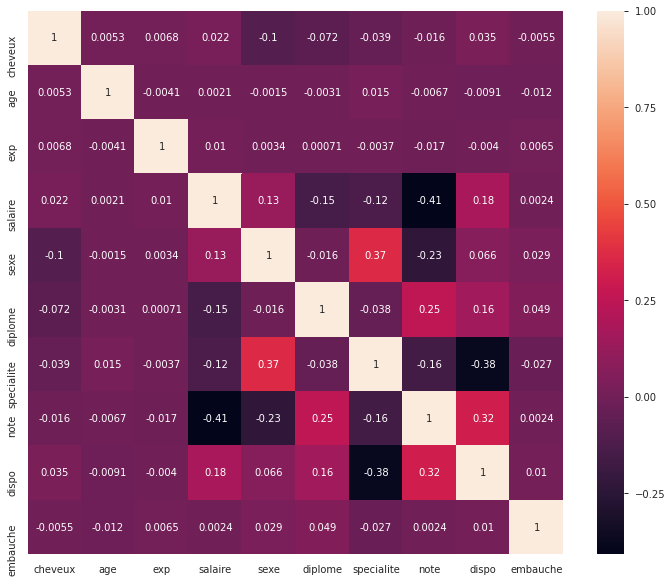

In [62]:
f, ax = plt.subplots(figsize=(12, 10))
corr = _data.corr()
sns.heatmap(corrMatrix, annot=True)

### Dépendance statistique
<ol type="a">
  <li>La spécialité et le sexe: La corrélation linéaire est 0.37 qui est certes non négligeable mais il se peut qu'il y ait des dépendances non linéaires</li> 
  <li>La couleur de cheveux et le salaire demandé: La corrélation est 0.022 qui est négligeable donc pas de dépendance linéaire.</li>
  <li>Le nombre d’années d’expérience et la note à l’exercice: La corrélation est de -0.017, certes lors de l'imputation j'ai pu forcer le fait qu'il y ait une relation entre l'experience et salaire cependant cete dépendence est trop faible, même négligeable</li>
</ol>

Afin de verifier qu'il n'y ait pas une correlation assez grande d'une variable par rapport à notre Y qui est embauche

In [63]:
cor_target = abs(CorrMatrix["embauche"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

embauche    1.0
Name: embauche, dtype: float64

Aprés vérification de la dépendence des variables explicatives et la variable à prédire, je procede à une visualisation des distributions des données (distribution de la variable et distribution conditionnelle (var1 par rapport à var2))

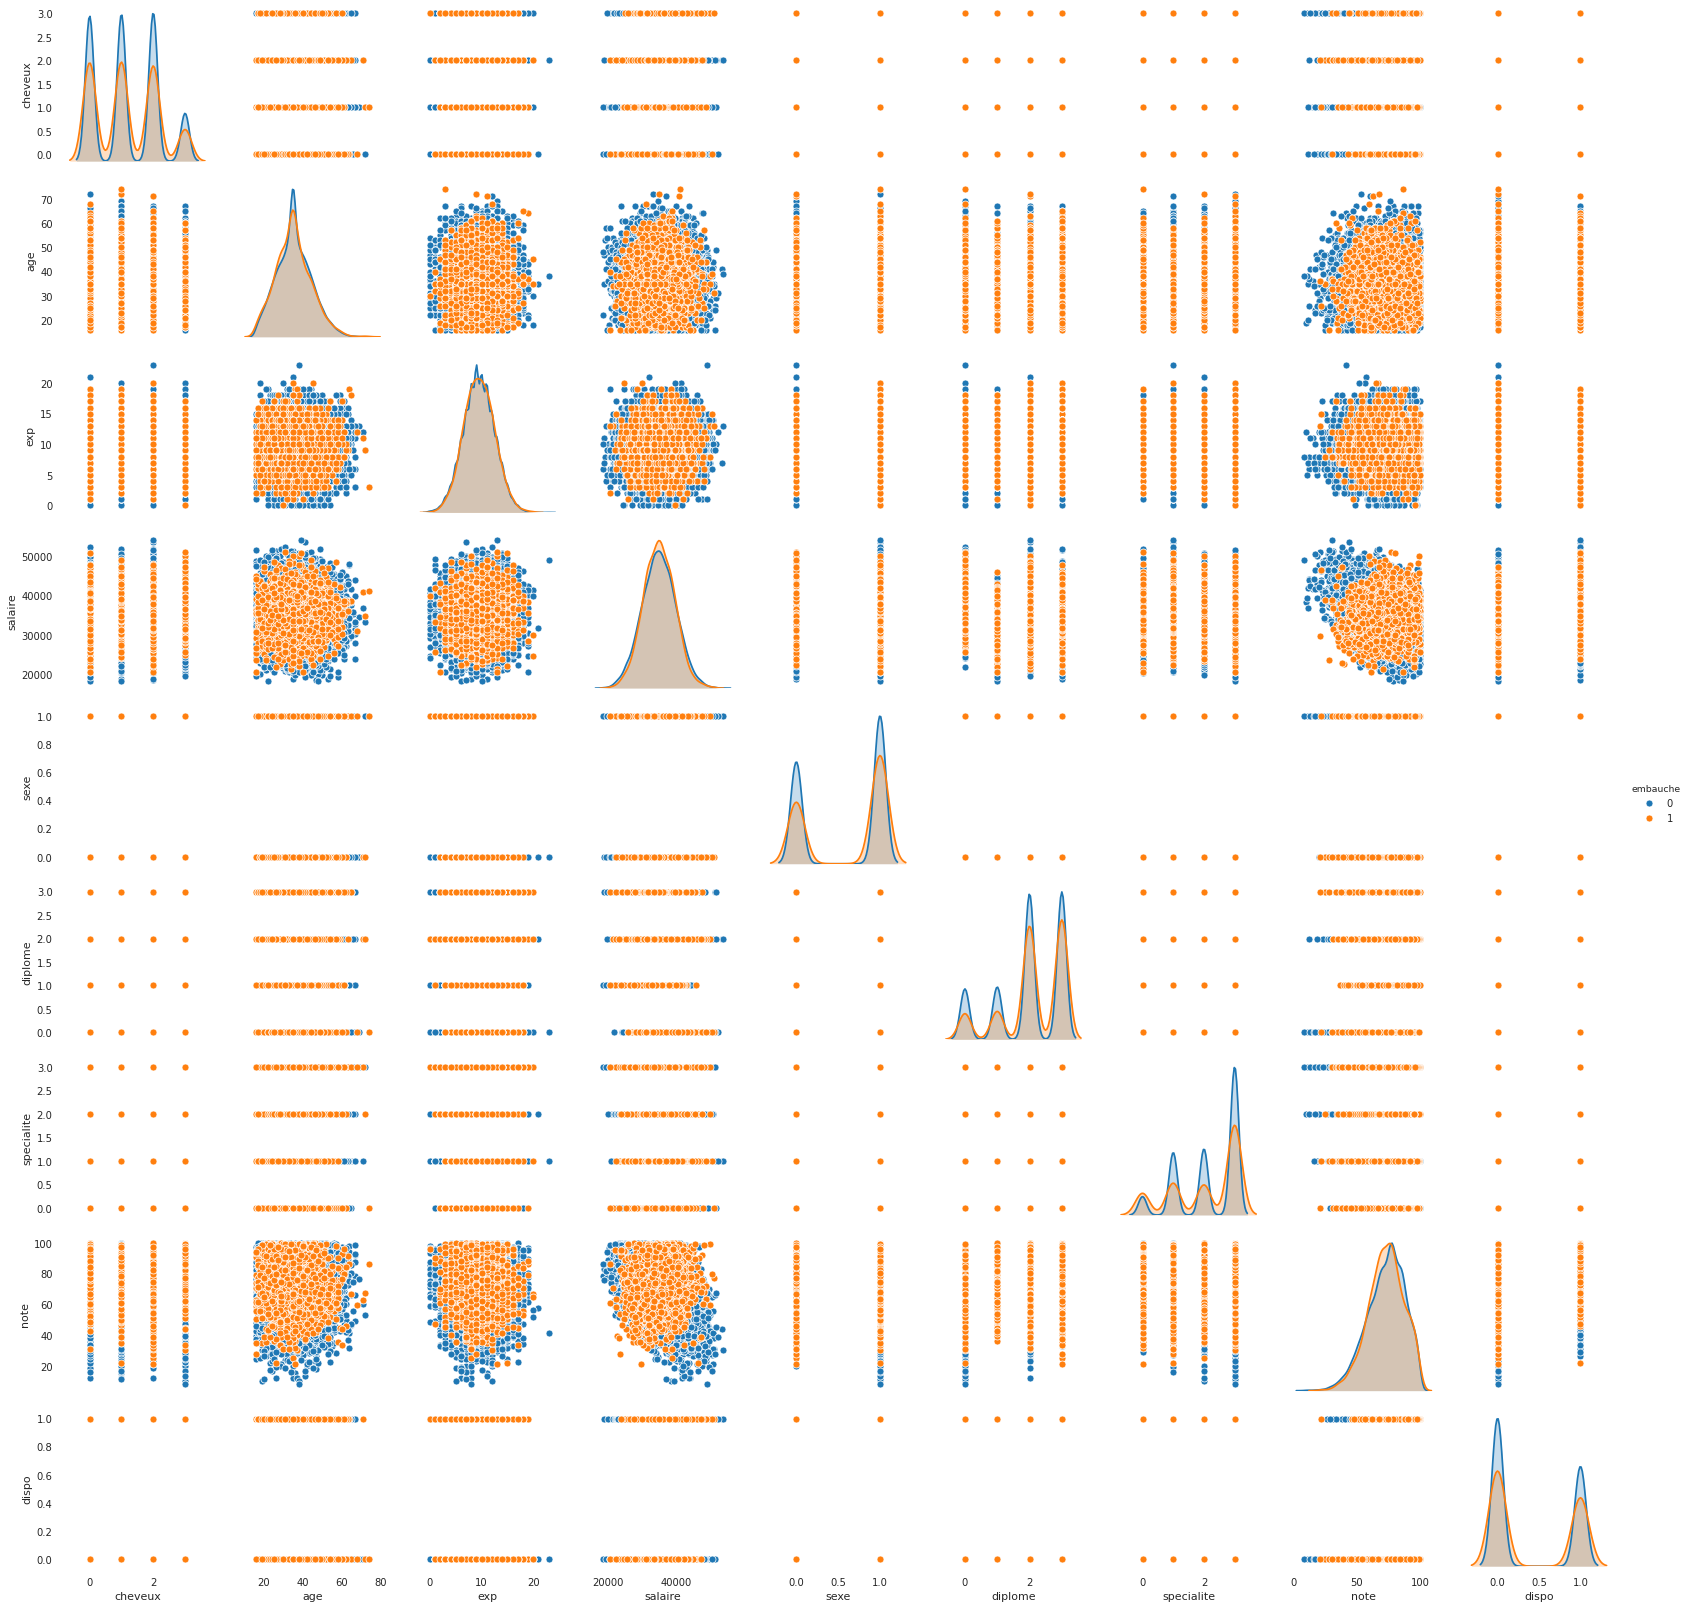

In [70]:
sns.pairplot(_data, hue='embauche', vars=['cheveux', 'age', 'exp', 'salaire', 'sexe', 'diplome', 'specialite',
                                          'note', 'dispo'])

# Modélisation

On commence deja par separer les X et les Y et puis splitter ces derniers en train et test sets 80/20.

Par soucis de reproductibilité je fixerais le random seed à 23

In [74]:
import random
random.seed(23)

y = _data['embauche']
X = _data.drop(['embauche'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

Pour le choix du modele, je vais mettre en place un XGBoost par soucis d'explicabilité.

Cependant à la fin du Notebook j'ajouterais une section bonus ou je mettrais en place 2 grands autres modeles que j'apprecie enormement.

Du coup afin d'assurer un meilleur choix de parametres je specifierais les range de valeurs et ferait une optimisation bayesienne.

In [100]:
rng_param = {'learning_rate': (0.01, 0.5),
             'n_estimators': (50, 500),
             'max_depth': (2,10),
             'subsample': (0.7, 1.0), # ici il choisira lors de l'apprentissage entre 70 et 100% des data aléatoirement
             'gamma': (0, 5)}

In [104]:
def xgboost_hyper_param(learning_rate, n_estimators, max_depth, subsample, gamma):
    
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    clf = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma)
    
    return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc'))

In [105]:
optimizer = BayesianOptimization(f=xgboost_hyper_param, pbounds=rng_param, random_state=23,)

In [106]:
optimizer.maximize(n_iter=5, init_points=10, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.8674   |  2.586    |  0.474    |  8.124    |  177.1    |  0.7663   |
|  2        |  0.8612   |  3.431    |  0.0919   |  5.14     |  328.1    |  0.8236   |
|  3        |  0.8486   |  0.01232  |  0.4432   |  9.08     |  185.2    |  0.8769   |
|  4        |  0.7793   |  4.892    |  0.4241   |  2.521    |  182.6    |  0.7864   |
|  5        |  0.7782   |  4.112    |  0.3168   |  2.884    |  50.24    |  0.9826   |
|  6        |  0.8699   |  0.7075   |  0.2166   |  4.772    |  441.4    |  0.8286   |
|  7        |  0.7753   |  4.144    |  0.3617   |  2.954    |  318.4    |  0.7389   |
|  8        |  0.8556   |  0.3877   |  0.4173   |  5.715    |  122.9    |  0.8644   |
|  9        |  0.8675   |  2.942    |  0.3891   |  7.247    |  301.0    |  0.7535   |
|  10       |  0.8669   |  1.203    |  0.258    |  5.1

Dans l'étape précedente, l'optimizer cherche les meilleures parametres qui permettrait de maximiser les résultats.

Et la ce qu'on va faire c'eest qu'aprés cette simulation on va extraire les parametres "optimaux".

In [107]:
params = optimizer.max['params']
print(params)

{'gamma': 0.7075037886259489, 'learning_rate': 0.21658229782141827, 'max_depth': 4.771915521188354, 'n_estimators': 441.40328797873167, 'subsample': 0.8285805437056859}


On remarque que certains parametres comme max_depth et n_estimators qui normalement devraient être des Int sont des floats d'ou la conversion que je vais faire maintenant

In [108]:
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

Maintenant créer un nouveau modéle avec les bons parametres

In [109]:
model = XGBClassifier(**params).fit(X_train, y_train)

Le modele en place, il est temps de lancer le test

In [111]:
from sklearn.metrics import classification_report

y_hat = model.predict(X_test)
print(classification_report(y_hat, y_test))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      3741
           1       0.40      0.73      0.51       259

    accuracy                           0.91      4000
   macro avg       0.69      0.83      0.73      4000
weighted avg       0.94      0.91      0.92      4000



La on se retrouve face à un modele qui perfome à 91% d'accuracy ce qui est bon, cependant j'ai remarqué un probleme que j'explique par la suite.

Il est temps de voir l'impact des variables sur la décision, ou autrement dit l'explicabilité du modéle.

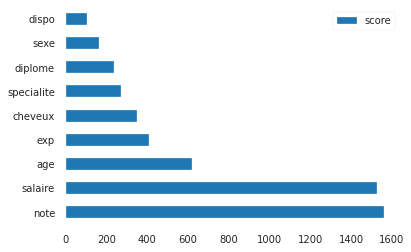

In [132]:
feature_important_w = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important_w.keys())
values = list(feature_important_w.values())

dt_w = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt_w.plot(kind='barh')

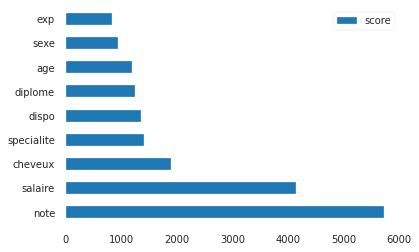

In [135]:
feature_important_g = model.get_booster().get_score(importance_type='total_gain')
keys = list(feature_important_g.keys())
values = list(feature_important_g.values())

dt_g = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
dt_g.plot(kind='barh')

Ainsi j'ai essayé de voir l'explicabilité par rapport aux poids des variables et au gain total en information, et il s'avere que la Note et le Salaire sont deux variables importantes pour permettre la prise de décision.

## Discussion

* Si on fait attention aux données dés le début du Notebook, on pourrait remarquer que les classes ne sont pas balancées, ce qui impacterait les performances de n'importe quel modele mis en place. D'ou le fait de repenser la stratégie que j'ai suivi et ajouter soit un subsampling ce qui nous ferait perdre des données soit un oversample qui va nous faire créer des data supplementaires "similaires" au précedent et ainsi on garantirait qu'on aura 50/50 pour les deux classes.

* Ce contre balancement des données peut être également vue au niveau de la matrice de confusion ou la performance sur les deux classes n'est pas proches (precision recall) bien qu'on a une accuracy globale de 91%

* J'ai choisi pour optimiser mon XGBoost RocAuc comme mesure etant donné qu'on traite une classification binaire, qui nous permet de maximiser les bonnes prédictions (Vrai Positif) par rapport aux mauvaises (Faux Positif).

## Piste d'amélioration

Comme j'ai pu dire je pourrais d'abord améliorer le balancing des classes, et puis pour les données manquantes ou faussées je pourrais mettre en place un autoencoder qui va prendre la donnée brute et la transformer en donné imputé et propre.
Finalement pour améliorer la variance du modele je proposerais une méthode de stacking par systeme de vote (voir le bonus), j'ai choisi de ne pas la mettre en place car difficilement explicable.

# Bonus

* Modele 1: Stacking de plusieurs modeles simples de Machine Learning qui permettront d'améliorer les prédictions par systeme de vote.

* Modele 2: Encoder + Classifier, c'est un modele que j'utilise des fois quand les données disposent de plusieurs variables et donc je crée des variables latentes pour eviter "the curse of dimensionality" (malédiction des dimensions)

#### Modele 1

In [137]:
lr = LogisticRegression(random_state=23)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8805

In [138]:
rf = RandomForestClassifier(random_state=23)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9175

In [139]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_test_pred = gnb.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8805

In [140]:
gbc = GradientBoostingClassifier(random_state=23)
gbc.fit(X_train, y_train)
y_test_pred = gbc.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.898

In [141]:
xgb = XGBClassifier(seed=23)
xgb.fit(X_train, y_train)
y_test_pred = xgb.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.913

In [142]:
modele_1 = VotingClassifier([('LogReg',lr),('RanFor',rf),('GaussNB',gnb),
                             ('GradBoost',gbc),('XGBoost',xgb)],
                            voting='hard')

In [143]:
modele_1 = modele_1.fit(X_train,y_train)

In [144]:
y_test_pred = modele_1.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8995

Le stacking de modéles nous permets d'avoir une accuracy de 89.95% bien que je n'ai pas pris le temps d'optimiser les differents parametres des modeles.

#### Modele 2

In [148]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

input_layer = Input(shape=(X_train.shape[1],))

## encoding part
encoded = Dense(6, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(3, activation='relu')(encoded)

## decoding part
decoded = Dense(3, activation='tanh')(encoded)
decoded = Dense(6, activation='tanh')(decoded)

## output layer
output_layer = Dense(X_train.shape[1], activation='relu')(decoded)

In [149]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [156]:
autoencoder.fit(X_train[0:5000], X_train[0:5000], 
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20);

Epoch 1/50
16/16 [==============================] - 0s 5ms/step - loss: 138414400.0000 - val_loss: 136903280.0000
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 138414400.0000 - val_loss: 136903280.0000
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 138414384.0000 - val_loss: 136903280.0000
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 138414400.0000 - val_loss: 136903280.0000
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 138414400.0000 - val_loss: 136903280.0000
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 138414400.0000 - val_loss: 136903280.0000
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 138414400.0000 - val_loss: 136903280.0000
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 138414432.0000 - val_loss: 136903280.0000
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 138414400.0000 -

In [157]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [158]:
latent_rep_train = hidden_representation.predict(X_train)
latent_rep_test = hidden_representation.predict(X_test)

In [159]:
clf = LogisticRegression(solver="lbfgs").fit(latent_rep_train, y_train)
pred_y = clf.predict(latent_rep_test)

In [162]:
print ("Classification Report: ")
print (classification_report(y_test, pred_y))

print ("\nAccuracy Score: ", accuracy_score(y_test, pred_y))

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3522
           1       0.00      0.00      0.00       478

    accuracy                           0.88      4000
   macro avg       0.44      0.50      0.47      4000
weighted avg       0.78      0.88      0.82      4000


Accuracy Score:  0.8805


On remarque ici que la performance est médiocre compte tenu de la matrice de confusion, mais cela reste un modéle qui pourrait donner d'assez bons résultats sur des Data avec plusieurs features et donc cela nous permettrait d'éviter toute tache de reduction de dimension en passant par PCA par exemple.